### Anisotropy

In this notebook, arrival times calculated with the Lax-Friedrich Eikonal solver are compared with synthetic waveforms obtained by full forward modeling (FWM) for a 
**3D Homogeneous VTI Medium**.

In [8]:
using SeisTimes

using GLMakie # for illustrations
Makie.inline!(true)

using YAML, JLD2, HDF5, ElasticFDSG  # for FWM
using Interpolations

In [9]:
# grid 
h = 1
x_coords = 0:h:200
y_coords = 0:h:100 
z_coords = 0:h:300
nx, ny, nz = length(x_coords), length(y_coords), length(z_coords)

# elastic propterties
vp   = zeros(nx, ny, nz) .+ 4442
vs   = zeros(nx, ny, nz) .+ 2350
eps  = zeros(nx, ny, nz) .+ 0.19
gam  = zeros(nx, ny, nz) .+ 0.27
del  = zeros(nx, ny, nz) .+ 0.37
del3 = zeros(nx, ny, nz);

# receivers
zstep = length(z_coords) ÷ 30
offset = zstep ÷ 2
receivers = [(10, 50, z) for z in z_coords[offset+1 : zstep : end-offset]]
rx = [r[1] for r in receivers]
ry = [r[2] for r in receivers]
rz = [r[3] for r in receivers]
println("Receivers: ", receivers[begin:2], " ... ", receivers[end-2:end] )
println("N-Receiver: ", size(receivers,1))

# source
source = (190, 50, 150)

Receivers: [(10, 50, 5), (10, 50, 15)] ... [(10, 50, 275), (10, 50, 285), (10, 50, 295)]
N-Receiver: 30


(190, 50, 150)

--- 

For FWM, we use ElasticFDSG (https://wtegtow.github.io/ElasticFDSG.jl/dev/).

To run fwm, we need to prepare:
- a configuration .yaml file
- a velocity model array .jld2 file

In [10]:
# FWM 
# prepare the config
config = Dict(
    "settings" => Dict(
        "device" => Symbol("gpu-metal"),  # :cpu / :gpu_cuda / :gpu_metal
        "precision" => :Float32,          # :Float64 / :Float32
        "spatial_derivative_order" => 10,             
        "show_summary_in_console" => true,
        "show_progress_in_console" => true,
        "save_results" => true,
        "output" => Dict(
            "destination_folder" => @__DIR__,
            "file_name" => "fwm_output",
            "format" => "h5"
        )
    ),
    
    "time" => Dict(
        "start" => 0.0,
        "end" => 0.15,
        "timestep" => 4e-5
    ),
    
    "source" => Dict(
        "dominant_frequency" => 150,
        "wavelet_type" => "ricker",                   # :ricker / :gauss1d
        "wavelet_center" => 0.008,
        "amplitude" => 1e10,
        "location" => Dict(
            "x" => source[1],
            "y" => source[2],
            "z" => source[3]
        ),
        "point_source" => Dict(
            "use" => true,
            "act_on" => Dict(
                "on_vx" => true,
                "on_vy" => true,
                "on_vz" => true,
                "on_all" => Dict(
                    "phi" => 30,
                    "theta" => 30
                )
            )
        ),
        "double_couple" => Dict(
            "use" => false,
            "strike" => 0,
            "dip" => 60,
            "rake" => 90, 
            "anisotropic_moment_tensor" => true
        )
    ),
    
    "boundaries" => Dict(
        "xstart" => "absorbing",
        "xend" => "absorbing",
        "ystart" => "absorbing",
        "yend" => "absorbing",
        "zstart" => "absorbing",
        "zend" => "absorbing"
    ),
    
    "pml" => Dict(
        "nlayer" => 10,
        "reflection_coefficient" => 1e-15
    ),
    
    "receivers" => Dict(
        "geophones" => [Dict("x"=>rx, "y"=>ry, "z"=>rz) for (rx, ry, rz) in receivers],

        "das" => Dict(
           "x_aligned" => Dict(),
           "y_aligned" => Dict(),
           "z_aligned" => Dict(),
        ),

        "snapshots" => Dict(
            "times" => [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.15],
            "fields" => ["vx", "vy", "vz"],
            "origins" => Dict("x" => source[1], "y" => source[2], "z" => source[3])
        )
    )
)

config_path = joinpath(@__DIR__,"fmw_cf.yaml")
open(config_path, "w") do io
    YAML.write(io, config)
end

# prepare the velocity model
nx = length(x_coords)
ny = length(y_coords)
nz = length(z_coords)

# 3D meshgrid
X = getindex.(Iterators.product(x_coords, y_coords, z_coords), 1)
Y = getindex.(Iterators.product(x_coords, y_coords, z_coords), 2)
Z = getindex.(Iterators.product(x_coords, y_coords, z_coords), 3)
dim = (nx, ny, nz)

veldim = (13, nx, ny, nz)
vmod = zeros(veldim);

vmod[1,:,:,:] .= X
vmod[2,:,:,:] .= Y
vmod[3,:,:,:] .= Z

vmod[4,:,:,:] .= vp
vmod[5,:,:,:] .= vs
vmod[6,:,:,:] .= 2000

vmod[7,:,:,:] .= eps
vmod[8,:,:,:] .= eps
vmod[9,:,:,:] .= gam
vmod[10,:,:,:] .= gam
vmod[11,:,:,:] .= del
vmod[12,:,:,:] .= del
vmod[13,:,:,:] .= del3

velmod_path = joinpath(@__DIR__,"velmod.jld2")
jldsave(velmod_path; velmod=vmod);

# run FWM
ElasticFDSG.dim3.runsim(config_path, velmod_path)

# load FWM results 
function extract_hdf5_content(file_path::String)
    file = h5open(file_path, "r")
    result = Dict()
    
    function process_group(group, prefix="")
        for name in keys(group)
            path = joinpath(prefix, name)
            obj = group[name]
            if obj isa HDF5.Group
                process_group(obj, path)
            elseif obj isa HDF5.Dataset
                result[path] = read(obj)
            else
                ;
            end
        end
    end
    
    process_group(file)
    close(file)
    return result
end;

output_path = joinpath(@__DIR__, "fwm_output.h5"); 
fwm_content = extract_hdf5_content(output_path);

println("Content keys")
for (key, value) in fwm_content
    println("$key ", size(value))
end

# delete large temporary files (to keep the repository clean)
rm(config_path)
rm(velmod_path)
rm(output_path)


╔══════════════════════════════════
║ FDSG 3D - Summary                
╠══════════════════════════════════
║ x-coords: 0.0: 1.0: 200.0       
║ y-coords: 0.0: 1.0: 100.0       
║ z-coords: 0.0: 1.0: 300.0       
║ #DoFs: 11587521                      
║ Appr. Memory: 0.86 GB          
║ time: 0.0: 4.0e-5: 0.15           
║ nt: 3751                         
║ device: Apple M2 Max                     
║ source x: 190.00                 
║ source y: 50.00                 
║ source z: 150.00                 
╚══════════════════════════════════


Progress: 100%|███████████████████████████| Time: 0:05:21 (85.60 ms/it)


Results saved.
Content keys
time (3751,)
snapshots_XZdata (8, 3, 301, 201)
geophones_x_indices (30,)
snapshots_times (8,)
snapshots_times_indices (8,)
geophones_data (30, 3, 3751)
snapshots_XYdata (8, 3, 101, 201)
x_coordinates (201,)
z_coordinates (301,)
snapshots_fieldnames (3,)
geophones_z_indices (30,)
geophones_y_indices (30,)
snapshots_YZdata (8, 3, 301, 101)
y_coordinates (101,)
geophones_coords (3, 30)


---

### Compute travel times with SeisTimes

To reduce computational costs, traveltimes are computed on a coarser grid. 
After the calculation, the results are resampled back to the original high-resolution grid.



In [11]:
# resizing helper
function resample_model_fields(x_coords, y_coords, z_coords, 
                               vp, vs, eps, del, gam, del3,
                               nx, ny, nz)

    x_new = range(first(x_coords), last(x_coords), length=nx)
    y_new = range(first(y_coords), last(y_coords), length=ny)
    z_new = range(first(z_coords), last(z_coords), length=nz)

    function resample(field)
        interp = interpolate((x_coords, y_coords, z_coords), field, Gridded(Linear()))
        data = [interp(x, y, z) for x in x_new, y in y_new, z in z_new]
        return data
    end

    return (x_fine = x_coords, y_fine = y_coords, z_fine = z_coords,
            x_coarse = x_new, y_coarse = y_new, z_coarse = z_new,
            vp = resample(vp),
            vs = resample(vs),
            eps = resample(eps),
            del = resample(del),
            gam = resample(gam),
            del3 = fill(0.0, nx, ny, nz) 
        )
end

function scale_back(resampled_field, meta)
   
    xc, yc, zc = meta.x_coarse, meta.y_coarse, meta.z_coarse
    xco, yco, zco = meta.x_fine, meta.y_fine, meta.z_fine

    itp = interpolate((xc, yc, zc), resampled_field, Gridded(Linear()))
    T_original = zeros(eltype(resampled_field), length(xco), length(yco), length(zco))

    for ix in eachindex(xco)
        for iy in eachindex(yco)
            for iz in eachindex(zco)
                T_original[ix, iy, iz] = itp(xco[ix], yco[iy], zco[iz])
            end
        end
    end
    return T_original
end

nx_ = ny_ = nz_ = 50 # coarse grid size
grid = resample_model_fields(x_coords, y_coords, z_coords, vp, vs, eps, del, gam, del3, nx_, ny_, nz_);

vti = Solid3D(grid.x_coarse, grid.y_coarse, grid.z_coarse, 
              grid.vp, grid.vs, 
              eps1=grid.eps, eps2=grid.eps, gam1=grid.gam, gam2=grid.gam,
              del1=grid.del, del2=grid.del, del3=grid.del3);

tt_qp = fast_sweep(vti, [source], :P,  :LxFS5, verbose=false, max_iter=1000, max_error_tol = 1e-5, viscosity_buffer = 8);
tt_s1 = fast_sweep(vti, [source], :S1, :LxFS5, verbose=false, max_iter=1000, max_error_tol = 1e-5, viscosity_buffer = 8);
tt_s2 = fast_sweep(vti, [source], :S2, :LxFS5, verbose=false, max_iter=1000, max_error_tol = 1e-5, viscosity_buffer = 8);

# scale travel time grid back to original sizes
tt_qp_fine = scale_back(tt_qp, grid);
tt_s1_fine = scale_back(tt_s1, grid);
tt_s2_fine = scale_back(tt_s2, grid);


---

### Visualize

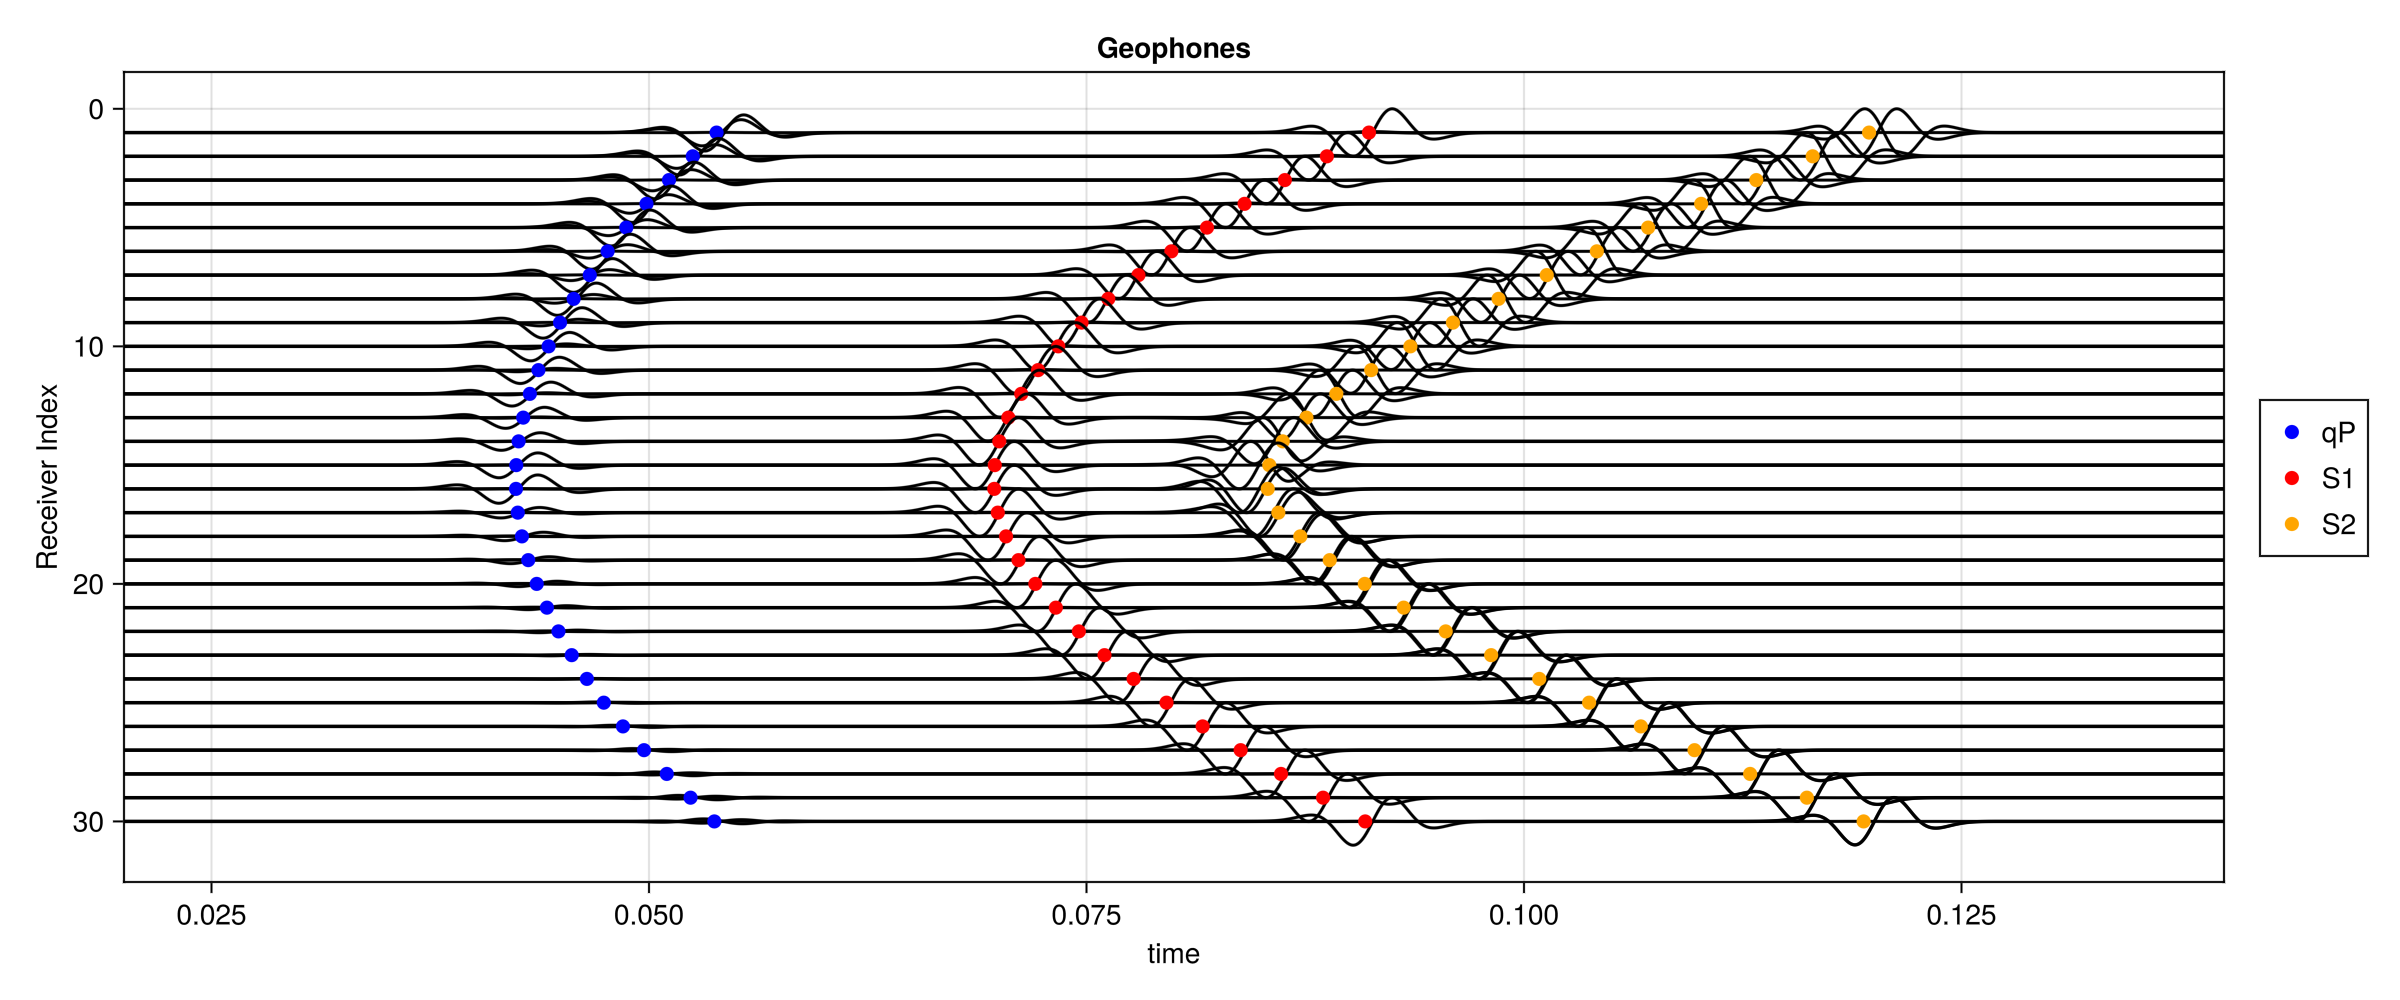

GLMakie.Screen(...)

In [12]:
function norm11(A)
    maxval = maximum(abs.(A))
    B = A ./ maxval
    return B
end

# geophone data 
t = fwm_content["time"]
geo_data  = fwm_content["geophones_data"]
geophones_coords = fwm_content["geophones_coords"]
tshift = config["source"]["wavelet_center"]

fig = Figure(size=(1200, 500))
ax1 = Axis(fig[1, 1], title="Geophones", ylabel="Receiver Index", xlabel="time", yreversed=true)

pq = s1 = s2 = nothing
for n in eachindex(receivers)

    # arrival times 
    rx, ry, rz = receivers[n]
    ix, iy, iz = argmin(abs.(rx .- x_coords)), argmin(abs.(ry .- y_coords)), argmin(abs.(rz .- z_coords))
    qp_arr = tt_qp_fine[ix, iy, iz] .+ tshift
    s1_arr = tt_s1_fine[ix, iy, iz] .+ tshift
    s2_arr = tt_s2_fine[ix, iy, iz] .+ tshift

    for c in 1:3
        lines!(ax1, t, norm11(geo_data[n,c,:]) .* 1 .+ n, color=:black)
    end 

    pq = scatter!(ax1, [qp_arr], [n], color=:blue, markersize=10)
    s1 = scatter!(ax1, [s1_arr], [n], color=:red, markersize=10)
    s2 = scatter!(ax1, [s2_arr], [n], color=:orange, markersize=10)
end

xlims!(ax1, 0.02, 0.14)
Legend(fig[1, 2],[pq,s1,s2],["qP", "S1", "S2"])
display(fig)